C:\Users\alexm\AppData\Local\Temp\ipykernel_30160\2154390125.py:97: UserWarning:

Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

C:\Users\alexm\AppData\Local\Temp\ipykernel_30160\2154390125.py:99: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



Число выбросов по методу z-отклонения: 3
3


Text(0.5, 1.0, 'Логарифмическое распределение по возрасту')

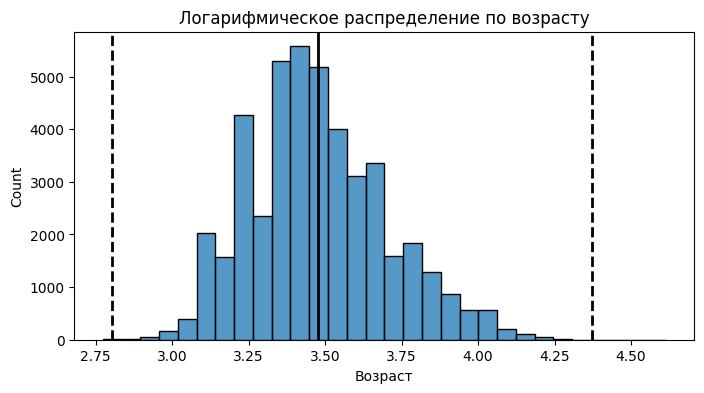

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
database = pd.read_csv('dst-3.0_16_1_hh_database.csv', sep = ';')
def education_data(value):
    value = ' '.join(value.split(' ')[:3])
    if 'Высшее' in value:
        return 'высшее'
    elif 'Неоконченное высшее' in value:
        return 'неоконченное высшее'
    elif 'Среднее специальное' in value:
        return 'среднее специальное'
    elif 'Среднее образование'in value:
        return 'среднее'
database['Образование'] = database['Образование и ВУЗ'].apply(education_data)
database = database.drop('Образование и ВУЗ', axis = 1)

def sex(value):
    if 'Мужчина' in value:
        return 'М'
    else:
        return 'Ж'
database['Пол'] = database['Пол, возраст'].apply(sex)

def ages(value):
    splitted_val = value.split(' ')
    words = ['лет','года','год']
    for index,item in enumerate(splitted_val):
        if item in words:
            return int(splitted_val[index-1])
database['Возраст'] = database['Пол, возраст'].apply(ages)
database = database.drop('Пол, возраст', axis = 1)

def work_experience(value):
    if value is np.nan or value == 'Не указано':
        return None
    years = ['год','года','лет']
    months = ['месяц','месяца','месяцев']
    splitted_val = value.split(' ')[:7]
    month = 0
    year = 0
    for index,item in enumerate(splitted_val):
        if item in years:
            year = int(splitted_val[index-1])
        if item in months:
            month = int(splitted_val[index-1])
    return int(year*12+month)
database['Опыт работы (месяц)'] = database['Опыт работы'].apply(work_experience)
database = database.drop('Опыт работы', axis = 1)

def city(value):
    million_cities = ['Новосибирск', 'Екатеринбург', 'Нижний Новгород', 'Казань', 'Челябинск', 'Омск',
                      'Самара', 'Ростов-на-Дону', 'Уфа', 'Красноярск', 'Пермь', 'Воронеж', 'Волгоград' ]
    splitted_city= value.split(' , ')[0]
    if (splitted_city=='Москва') or (splitted_city=='Санкт-Петербург'):
        return splitted_city
    elif splitted_city in million_cities:
        return 'город миллионник'
    else:
        return 'другие'
database['Город'] = database['Город, переезд, командировки'].apply(city)

def relocate(value):
    male_no = 'не готов'
    female_no = 'не готова'
    if (male_no in value) or (female_no in value):
        return False
    elif 'хочу' in value:
        return True
    else:
        return True
database['Готовность к переезду'] = database['Город, переезд, командировки'].apply(relocate)

def business_trip(value):
    male_no = 'не готов к командировкам'
    female_no = 'не готова к командировкам'
    if ('командировка' in value):
        if (male_no in value) or (female_no in value):
            return False
        else:
            return True
    else:
        return False
database['Готовность к командировкам'] = database['Город, переезд, командировки'].apply(business_trip)
database = database.drop('Город, переезд, командировки', axis = 1)

kind_of_employ = ['полная занятость','частичная занятость','проектная работа','волонтерство','стажировка']
schedule = ['полный день','сменный график','гибкий график','удалённая работа','вахтовый метод']
for index,value in zip(kind_of_employ,schedule):
    database[index] = database['Занятость'].apply(lambda x: index in x)
    database[value] = database['График'].apply(lambda x: value in x)
database = database.drop('Занятость', axis = 1)
database = database.drop('График', axis = 1)

database['Обновление резюме'] = pd.to_datetime(database['Обновление резюме']).dt.date
currency_data = pd.read_csv('ExchangeRates.csv', sep = ',')
currency_data['date'] = pd.to_datetime(currency_data['date']).dt.date
currency_data = currency_data.drop(['per','time','vol'],axis = 1)

def find_salary(value):
    salary = float(value.split(' ')[0])
    return salary
database['ЗП желаемая'] = database['ЗП'].apply(find_salary)

def currency_name(value):
    currency_dict = {'USD':'USD', 'KZT':'KZT','грн':'UAH','белруб':'BYN','EUR':'EUR','KGS':'KGS','сум':'UZS','AZN':'AZN'}
    currency = value.split(' ')[1].replace('.','')
    if currency == 'руб':
        return 'RUB'
    else:
        return currency_dict[currency]
database['курс'] = database['ЗП'].apply(currency_name)

merged = database.merge(currency_data, left_on=['курс','Обновление резюме'], right_on = ['currency','date'], how='left')
merged['close'] = merged['close'].fillna(1)
merged['proportion'] = merged['proportion'].fillna(1)
database['ЗП (руб)'] = merged['ЗП желаемая']*merged['close']/merged['proportion']
database =database.drop(['ЗП','ЗП желаемая','курс'], axis = 1)

fig = px.histogram(data_frame = database, x ='Возраст', title = 'Распределение возраста соискателей', width = 500, marginal = 'box')
#fig.show()

fig = px.histogram(data_frame = database, x ='Опыт работы (месяц)', title = 'Распределение опыта работы', width = 500, marginal = 'box')
#fig.show()

fig = px.histogram(data_frame = database, x ='ЗП (руб)', title = 'Распределение ЗП в рублях', width = 8000,  marginal = 'box')
#fig.show()

bar_database = database.groupby('Образование', as_index = False)['ЗП (руб)'].median()
fig = px.bar(data_frame = bar_database, x = 'Образование', y = 'ЗП (руб)', color = 'Образование', title = 'ЗП медианное по Образованию')
#fig.show()

box_database = database[database['ЗП (руб)']<1e6]
fig = px.box(data_frame = box_database, x = 'Город', y = 'ЗП (руб)', color = 'Город', title = 'Распределение ЗП по городам')
#fig.show()

bars_database = database.groupby(['Готовность к командировкам','Готовность к переезду'], as_index=False)['ЗП (руб)'].median()
fig = px.bar(data_frame= bars_database, y = 'Готовность к переезду', x = 'ЗП (руб)', barmode='group', color = 'Готовность к командировкам', title = 'ЗП по готовности')
#fig.show()

pivot_data = database.pivot_table(values = 'ЗП (руб)', index = 'Возраст', columns = 'Образование',fill_value=0, aggfunc='median')
#fig = sns.heatmap(data = pivot_data,cmap='terrain')

database['Опыт работы (год)'] = database['Опыт работы (месяц)']/12
#sns.lineplot(x = [0,100], y = [0,100])
#fig = sns.scatterplot(data = database, x = 'Возраст' , y = 'Опыт работы (год)')

dupl_columns = list(database.columns)#обращаемся к списку колонок в таблице
mask = database.duplicated(subset=dupl_columns)
# теперь, по маске ищем дубликаты и выводим их к-во
hh_duplicates = database[mask]
#print(f'Число найденных дубликатов: {hh_duplicates.shape[0]}')
database = database.drop_duplicates(subset=dupl_columns)

data_null = database.isnull().sum()
#print(data_null[data_null>0])

database = database.dropna(subset = ['Последнее/нынешнее место работы','Последняя/нынешняя должность'])
database['Опыт работы (месяц)'] = database['Опыт работы (месяц)'].fillna(database['Опыт работы (месяц)'].median())
#print(round(database['Опыт работы (месяц)'].mean()))

out = database[(database['ЗП (руб)']<1e3) | (database['ЗП (руб)']>1e6)]
database = database.drop(out.index)
#print(out_age.shape[0])
out_age = database[database['Опыт работы (год)']> database['Возраст']]
database = database.drop(out_age.index)
#print(out_age.shape[0])

def outliers_z_score_mod(database, feature, left=4, right=4, log_scale=True):
    if log_scale:
        x = np.log(database[feature]+1)
    else:
        x = database[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = database[(x < lower_bound) | (x > upper_bound)]
    cleaned = database[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned
outliers, cleaned = outliers_z_score_mod(database, 'Возраст',left = 3, right = 4, log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(outliers.shape[0])
fig, ax = plt.subplots(1,1, figsize = (8,4))
log_age = np.log(database['Возраст']+1)
histplot = sns.histplot(log_age, bins = 30, ax=ax)
histplot.axvline(log_age.mean(), color = 'k', lw = 2)
histplot.axvline(log_age.mean()+4*log_age.std(), color = 'k', ls = '--', lw = 2)
histplot.axvline(log_age.mean()-3*log_age.std(), color = 'k', ls = '--', lw = 2)
histplot.set_title('Логарифмическое распределение по возрасту')